In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd
df = pd.read_csv('fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [8]:
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes = np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
df.Usage.value_counts() 

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [9]:
k = np.array(list(map(int,df.iloc[0,1].split(" "))),dtype='uint8').reshape((48,48))
k.shape

(48, 48)

In [10]:
X_train = []
y_train = []
X_test = []
y_test = []
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [11]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

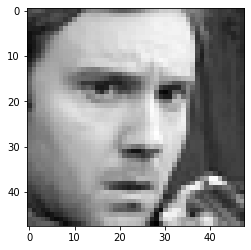

In [12]:
plt.imshow(np.array(X_train[0], dtype = 'uint8').reshape(48,48,1), cmap = 'gray') #plotting 48x48 image from pixels in selected sample

In [13]:
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [14]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)


In [15]:
X_train.shape

(28709, 48, 48, 1)

In [16]:
import tensorflow.keras
from tensorflow.keras.utils import to_categorical
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
datagen = ImageDataGenerator( 
    rescale=1./255,
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator( 
    rescale=1./255
    )
datagen.fit(X_train)
batch_size = 64 

In [18]:
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size) 
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)


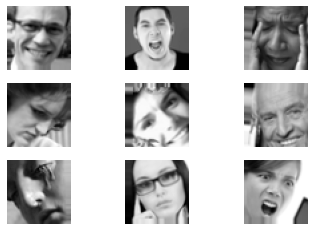

In [19]:
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9): 
        plt.axis('off') 
        plt.subplot(330 + 1 + i) 
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))
    plt.axis('off') 
    plt.show() 
    break

In [20]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [21]:
def FER_Model(input_shape=(48,48,1)):
    #first input model
    visible = Input(shape=input_shape, name='input')
    
    num_classes = 7
    #1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)#the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)#the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)#the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)
    
    #5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)#Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model 
    model = Model(inputs =visible, outputs = ouput)
    
    #summary layers
    print(model.summary())
    
    return model

In [22]:
model = FER_Model()
opt = Adam(lr=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0     

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [23]:
num_epochs = 50
history = model.fit(train_flow, 
                    steps_per_epoch=20, 
                    epochs=num_epochs,  
                    verbose=1,  
                    validation_data=test_flow,
                    validation_steps=len(X_test) / batch_size)

Epoch 1/50
20/20 [==============================] - 168s 8s/step - loss: 2.5183 - accuracy: 0.1797 - val_loss: 1.9287 - val_accuracy: 0.2494
Epoch 2/50
20/20 [==============================] - 157s 8s/step - loss: 2.3474 - accuracy: 0.1953 - val_loss: 1.9086 - val_accuracy: 0.2494
Epoch 3/50
20/20 [==============================] - 155s 8s/step - loss: 2.2744 - accuracy: 0.2062 - val_loss: 1.8849 - val_accuracy: 0.2494
Epoch 4/50
20/20 [==============================] - 159s 8s/step - loss: 2.1913 - accuracy: 0.2125 - val_loss: 1.8691 - val_accuracy: 0.2494
Epoch 5/50
20/20 [==============================] - 154s 8s/step - loss: 2.2122 - accuracy: 0.2125 - val_loss: 1.8881 - val_accuracy: 0.2494
Epoch 6/50
20/20 [==============================] - 159s 8s/step - loss: 2.1915 - accuracy: 0.2094 - val_loss: 1.9172 - val_accuracy: 0.2494
Epoch 7/50
20/20 [==============================] - 143s 7s/step - loss: 2.1680 - accuracy: 0.2070 - val_loss: 1.9045 - val_accuracy: 0.2494
Epoch 8/50
20

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import load_model, model_from_json
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing import image


<Figure size 432x288 with 0 Axes>

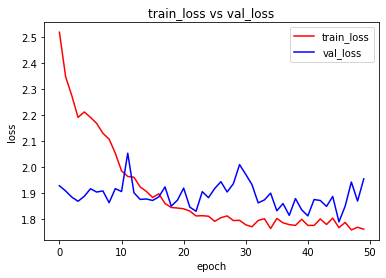

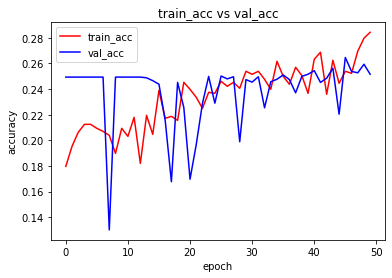

<Figure size 432x288 with 0 Axes>

In [25]:
%matplotlib inline

train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure()

plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.figure()

In [26]:
model.save('./Fer2013.h5') #backing up working model and weights


In [27]:
loss = model.evaluate(X_test/255., y_test) 
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))


113/113 [==============================] - 60s 527ms/step - loss: 1.9552 - accuracy: 0.2516
Test Loss 1.9552215337753296
Test Acc: 0.2516021132469177


113/113 [==============================] - 63s 522ms/step


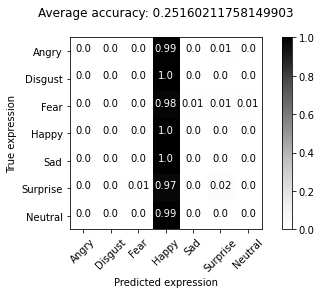

In [28]:
import itertools
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)
    
    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        
    np.set_printoptions(precision=2)
        
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys,   title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')

In [29]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [3]:
model = model_from_json(open("./model.json", "r").read()) #reading the saved model from training
model.load_weights('./model.h5') #loading the weights from saved file after training
classifier = cv2.CascadeClassifier('haarcascade_frontalface_default.xml') #initializing classifier to detect faces using haar_cascade
cap = cv2.VideoCapture(0) #initializing camera using cv2 to capture face

In [4]:
while cap.isOpened():
    #setting up the camera frame and UI
    res, frame = cap.read()
    height, width , channel = frame.shape
    sub_img = frame[0:int(height / 9),0:int(width)]
    rect = np.ones(sub_img.shape, dtype = np.uint8) * 0
    res = cv2.addWeighted(sub_img, 0.77, rect, 0.23, 0)
    
    #styling font and label properties
    FONT = cv2.FONT_HERSHEY_TRIPLEX
    FONT_SCALE = 0
    FONT_THICKNESS = 0
    label_color = (64, 255, 0)
    label = ""
    
    #positioning
    label_dimension = cv2.getTextSize(label, FONT, FONT_SCALE, FONT_THICKNESS)[0]
    textX = int((res.shape[1] - label_dimension[0]) / 2)
    textY = int((res.shape[0] + label_dimension[1]) / 2)
    cv2.putText(res, label, (textX, textY), FONT, FONT_SCALE, (255, 255, 255), FONT_THICKNESS)
    
    #capturing faces and converting the images to grayscale
    gray_image = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = classifier.detectMultiScale(gray_image)
    
    try:
        for (x, y, w, h) in faces:
            #selecting Region of Interest(ROI) from camera
            cv2.rectangle(frame, pt1 = (x, y), pt2 = (x+w, y+h), color = (64, 255, 0),thickness =  2)
            roi_gray = gray_image[y-5 : y+h+5, x-5 : x+w+5]
            roi_gray = cv2.resize(roi_gray, (48,48))
            image_pixels = img_to_array(roi_gray) #converting image to array for prediction of emotions
            image_pixels = np.expand_dims(image_pixels, axis = 0)
            image_pixels /= 255
            predictions = model.predict(image_pixels) #using the model to predict emotions
            max_index = np.argmax(predictions[0]) #storing max prediction value to max_index
            emotions = ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral')
            emotion_prediction = emotions[max_index] #selecting matching prediction from emotions tuple
            
            #displaying prediction and accuracy as labels in UI
            cv2.putText(res, "Emotion: {}".format(emotion_prediction), (40, textY+5+5), FONT, 0.7, label_color, 1)
            label_violation = 'Accuracy: {}'.format(str(np.round(np.max(predictions[0]) * 100, 1)) + "%")
            cv2.putText(res, label_violation, (400, textY+5+5), FONT, 0.7, label_color, 1)
    except:
        pass
    
    frame[0:int(height / 9), 0:int(width)] = res
    cv2.imshow('Face Emotion Detector (19033540)', frame) #frame (window) title

    #exit application on pressing 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 28ms/step


KeyboardInterrupt: 

In [1]:
cd  C:\ProgramData\Anaconda3\keras

C:\ProgramData\Anaconda3\keras


In [6]:
import os
import cv2
emotion={0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise"}

# CREATING FOLDERS FOR EACH OF THE EXPRESSION INSIDE THE TRAIN FOLDER
for i in range(0,6):
    os.makedirs(os.path.join(base_dir,r'train',emotion[i]),exist_ok=True)

# LOADING TRAINING PICTURES FROM DATA FRAME TO RESPECTIVE FOLDERS
c=0
for i in range(6):
    temp=ds[(ds['emotion']==i) & (ds['Usage']=='Training')]
    for k in range(len(temp)):
        pix=temp.iloc[k]['pixels']
        img=np.array([int(j) for j in pix.split(' ')])
        img=np.reshape(img,(48,48))
        cv2.imwrite(os.path.join(base_dir,r'train',emotion[temp.iloc[k]['emotion']],(str)(c)+'.jpg'),img)
        c=c+1
    

# CREATING FOLDERS FOR EACH OF THE EXPRESSION INSIDE THE VALID FOLDER(FOLDER FOR VALIDATION DATA)
for i in range(0,6):
    os.makedirs(os.path.join(base_dir,r'valid',emotion[i]),exist_ok=True)

c=0
for i in range(6):
    temp=ds[(ds['emotion']==i) & (ds['Usage']=='PublicTest')]
    for k in range(len(temp)):
        pix=temp.iloc[k]['pixels']
        img=np.array([int(j) for j in pix.split(' ')])
        img=np.reshape(img,(48,48))
        cv2.imwrite(os.path.join(base_dir,r'valid',emotion[temp.iloc[k]['emotion']],(str)(c)+'.jpg'),img)
        c=c+1

In [1]:
base_dir = r'C:\Users\Aaditya Saroj Rai'

In [2]:
f_p=base_dir+r'\fer2013.csv'

In [5]:
ds=pd.read_csv(f_p)

In [25]:
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import keras
from keras import models,layers,regularizers,optimizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.models import load_model,model_from_json
import pandas as pd
from sklearn.metrics import confusion_matrix



# LOADING THE PRETRAINED VGG MODEL WITH IMAGENET WEIGHTS
# INCLUDE_TOP = FALSE (ONLY TAKING CONVOLUTIONAL BASE)
Model=applications.VGG16(include_top=False,weights='imagenet',input_shape=(48,48,3))
Model.summary()


#CREATING A SEQUENTIAL MODEL OUT OF VGG FOR FEATURE EXTRACTION
model=models.Sequential()

# ADDING ONLY 11 LAYERS OF VGG
for i in Model.layers[:11]:
    model.add(i)

# SETTING ALL THESE LAYERS AS NOT TRAINABLE
for i in model.layers:
    i.trainable=False


# CREATING A MODEL ON TOP OF VGG TO PROCESS THE FEATURES EXTRACTED OUT OF THE VGG MODEL
VGGtop=models.Sequential()
VGGtop.add(layers.Conv2D(512,(3,3),input_shape=(6,6,256),kernel_regularizer=regularizers.l2(0.01)))
VGGtop.add(layers.Conv2D(512,(3,3),kernel_regularizer=regularizers.l2(0.01)))
VGGtop.add(layers.MaxPool2D((2,2)))
VGGtop.add(layers.Flatten())
VGGtop.add(layers.Dense(128,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
VGGtop.add(layers.Dropout(0.5))
VGGtop.add(layers.Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.05)))
VGGtop.add(layers.Dense(6,activation='softmax'))

VGGtop.summary()

VGGtop.compile(optimizer=optimizers.SGD(lr=0.009),loss='categorical_crossentropy',metrics=['accuracy'])


train_datagen=ImageDataGenerator(rescale=1./255,zoom_range=0.2,shear_range=0.2,horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)


train_datagenerator=train_datagen.flow_from_directory(os.path.join(base_dir,r'train'),target_size=(48,48),class_mode='categorical',batch_size=128)
valid_datagenetor=test_datagen.flow_from_directory(os.path.join(base_dir,r'valid'),target_size=(48,48),class_mode='categorical',batch_size=128)


# EXTRACTING FEATURES OF TRAINING DATA BY PASSING THEM THROUGH VGG MODEL
X_features=np.zeros(shape=(27520,6,6,256))
X_labels=np.zeros(shape=(27520,6))
i=0
for inputs_batch,labels_batch in train_datagenerator:
    X_features[i*128:(i+1)*128]=model.predict(inputs_batch,verbose=1)
    X_labels[i*128:(i+1)*128]=labels_batch
    i+=1
    if i*128>=27520:
        break

#EXTRACTING FEATURES OF VALIDATION DATA BY PASSING THEM THROUGH VGG MODEL
V_features=np.zeros(shape=(3584,6,6,256))
V_labels=np.zeros(shape=(3584,6))
i=0
for inputs_batch,labels_batch in valid_datagenetor:
    V_features[i*128:(i+1)*128]=model.predict(inputs_batch,verbose=1)
    V_labels[i*128:(i+1)*128]=labels_batch
    i+=1
    if i*128>=3584:
        break

#LIMITING THE SIZE OF VALIDATION FEATURES EXTRACTED(TO ADJUST THE BATCH SIZE AND STEPS PER EPOCH)
V_features=V_features[:3456]
V_labels=V_labels[:3456]


# CODE TO SAVE AND LOAD THE FEATURES
np.save(os.path.join(base_dir,r'X_features'),X_features)
np.save(os.path.join(base_dir,r'X_labels'),X_labels)
np.save(os.path.join(base_dir,r'V_features'),V_features)
np.save(os.path.join(base_dir,r'V_labels'),V_labels)

X_features=np.load(os.path.join(base_dir,r'X_features.npy'))
X_labels=np.load(os.path.join(base_dir,r'X_labels.npy'))
V_features=np.load(os.path.join(base_dir,r'V_features.npy'))
V_labels=np.load(os.path.join(base_dir,r'V_labels.npy'))


checkpoint=ModelCheckpoint(os.path.join(base_dir,r'Checkpointx.hdf5'),monitor='val_loss',mode='min',save_best_only=True,verbose=1)


# TRAINING THE MODEL
history=VGGtop.fit(X_features,X_labels,epochs=50,batch_size=128,validation_data=(V_features,V_labels),callbacks=[checkpoint],verbose=1)

# SAVING MODEL
open(r'VGGtopModel2.json','w').write(VGGtop.to_json())

# LOADING MODEL WEIGHTS(JUST CODE,ALREADY SAME WEIGHTS ARE LOADED)
VGGtop.load_weights(os.path.join(base_dir,r'Checkpointx.hdf5'))


# NOW THE PART OF DETECTING THE EMOTIONS IN REAL TIME USING WEB VIDEO 
import cv2
import dlib


emotion={0:'Angry',1:'Fear',2:'Happy',3:'Neutral',4:'Sad',5:'Surprise'}

fd=dlib.get_frontal_face_detector()


# DETECTING MULTIPLE FACES IN THE FRAME AND DETECTING FACE EMOTION FOR EVERY FACE
cam=cv2.VideoCapture(0)
while True:
    ret,img=cam.read()
    temp1=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=fd(img,1)
    x=[]
    y=[]
    w=[]
    h=[]
    flag=False
    for i,f in enumerate(faces):
        flag=True
        a=f.left()
        b=f.top()
        x.append(a)
        y.append(b)
        w.append(f.right()-a)
        h.append(f.bottom()-b)
        
    #temp=img[y:y+h,x:x+w]
    if flag==True:
        for i in range(len(x)):
            cv2.imwrite(os.path.join(base_dir,r'temp.jpg'),temp1[y[i]:y[i]+h[i],x[i]:x[i]+w[i]])
            temp=cv2.imread(os.path.join(base_dir,r'temp.jpg'))
            temp=cv2.resize(temp,(48,48))
            temp=temp/255
            p=VGGtop.predict(model.predict(temp.reshape(1,48,48,3)))
            p=p.argmax()
            cv2.putText(img,emotion[p],(x[i]-20,y[i]),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,255))
    
        
    cv2.imshow('IMAGE',img)
    if cv2.waitKey(1) & 0xFF==ord('q'):
        break
    
        
        
cv2.destroyAllWindows()    
cam.release()

58889256/58889256 [==============================] - 44s 1us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                             

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Found 23744 images belonging to 6 classes.
Found 2982 images belonging to 6 classes.
4/4 [==============================] - 1s 129ms/step


2/2 [==============================] - 0s 129ms/step


ValueError: could not broadcast input array from shape (64,6,6,256) into shape (128,6,6,256)